# Basic Model

In [159]:
import pandas as pd
import numpy as np
import datetime
import networkx as nx

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [117]:
# Load and preprocess data
otc_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinotc.csv.gz')
alpha_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinalpha.csv.gz')
alpha_users = h.user_activity_dataframe(alpha_df)
otc_users = h.user_activity_dataframe(otc_df)

In [113]:
# # Load Feature Data

# df_b = pd.read_csv('../data/df_b.csv')
# df_dv = pd.read_csv('../data/df_dv.csv')
# df_sv = pd.read_csv('../data/df_sv.csv')
# df_gf = pd.read_csv('../data/df_gf.csv')
# df_graph_test = pd.read_csv('../data/df_graph_test.csv')

In [ ]:
# df_gr = pd.read_csv('../data/alpha_with_ratee_stats.csv')
# df_gr = df_gr[['rater','ratee','rating', 'date', 'class','cluster_coef','num_cliques']]
# # df_gr = df_gr[['rater','ratee','rating', 'date', 'class','num_cliques']]
# # df_gf.drop('cluster_coef', axis=1, inplace=True)

In [118]:
# df_graph_test.drop(['binomial_rating','color','penwidth'], axis=1, inplace=True)
# cols = ['ratee','rater','date','rating','class']
# features_df = pd.merge(pd.merge(pd.merge(pd.merge(df_graph_test,df_dv,on=cols),df_sv,on=cols),df_b,on=cols),df_gf,on=cols)
# features_df.drop(['binomial_rating','color','penwidth'], axis=1, inplace=True)

What is the range of user numbers in the networks?

In [ ]:
df = features_df
df[df['num_ratings_received']==0]['class'].sum()

## Alpha features

In [160]:
df_alpha_features = pd.read_csv('../data/df_features_alpha.csv')
df_alpha_velocity = pd.read_csv('../data/df_dv.csv')

merge_cols = ['ratee','rater','date','rating','class']
features_df = pd.merge(df_alpha_features, df_alpha_velocity, on=merge_cols)

features_df.drop(['binomial_rating', 'color', 'penwidth'], inplace=True, axis=1)

## OTC features

In [145]:
df_otc_features = pd.read_csv('../data/df_features_otc.csv')
df_otc_velocity = pd.read_csv('../data/df_otc_vd.csv')

merge_cols = ['ratee','rater','date','rating','class']
features_df = pd.merge(df_otc_features, df_otc_velocity, on=merge_cols)

features_df.drop(['binomial_rating', 'color', 'penwidth'], inplace=True, axis=1)

### drop graph features

In [84]:
graph_cols = ['ego_triad_300', 'ego_triad_210', 'ego_triad_201', 
              'ego_triad_120', 'ego_triad_all', 'ego_cluster_coef', 
              'ego_degree', 'ego_betweeness', 'ego_closeness', 'ego_num_cliques']
features_df.drop(graph_cols, inplace=True, axis=1)

### drop velocity features

In [161]:
velocity_cols = ['vel_24_in_pos','vel_24_in_all','vel_24_out_pos',
                 'vel_24_out_neg','vel_24_out_all','vel_24_all',
                 'vel_48_in_pos','vel_48_in_all','vel_48_out_pos',
                 'vel_48_out_neg','vel_48_out_all','vel_48_all'] 
features_df.drop(velocity_cols, inplace=True, axis=1)

## Predictive Model

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

X = features_df.copy()
X = X.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = X.pop('class')


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, shuffle=True,
                                                    random_state=123)

RF = RandomForestClassifier(n_jobs=-1, random_state=123)
RF.fit(X_train, y_train)
y_preds = RF.predict(X_test)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)

# print(X_test[(y_preds==0) & (X_test['num_neg_received']>0)].head(10))
print(recall)
print(precision)
RF.feature_importances_

0.5963541666666666
0.8035087719298246


array([0.03863645, 0.03531296, 0.04183561, 0.05986178, 0.15276484,
       0.13523454, 0.07757351, 0.09250563, 0.05924303, 0.05256919,
       0.01803136, 0.01997645, 0.02515387, 0.01762209, 0.02441937,
       0.02689706, 0.02491631, 0.02852753, 0.02574845, 0.0267237 ,
       0.0083664 , 0.00807984])

Text(0.5,1,'Random Forest feature importance')

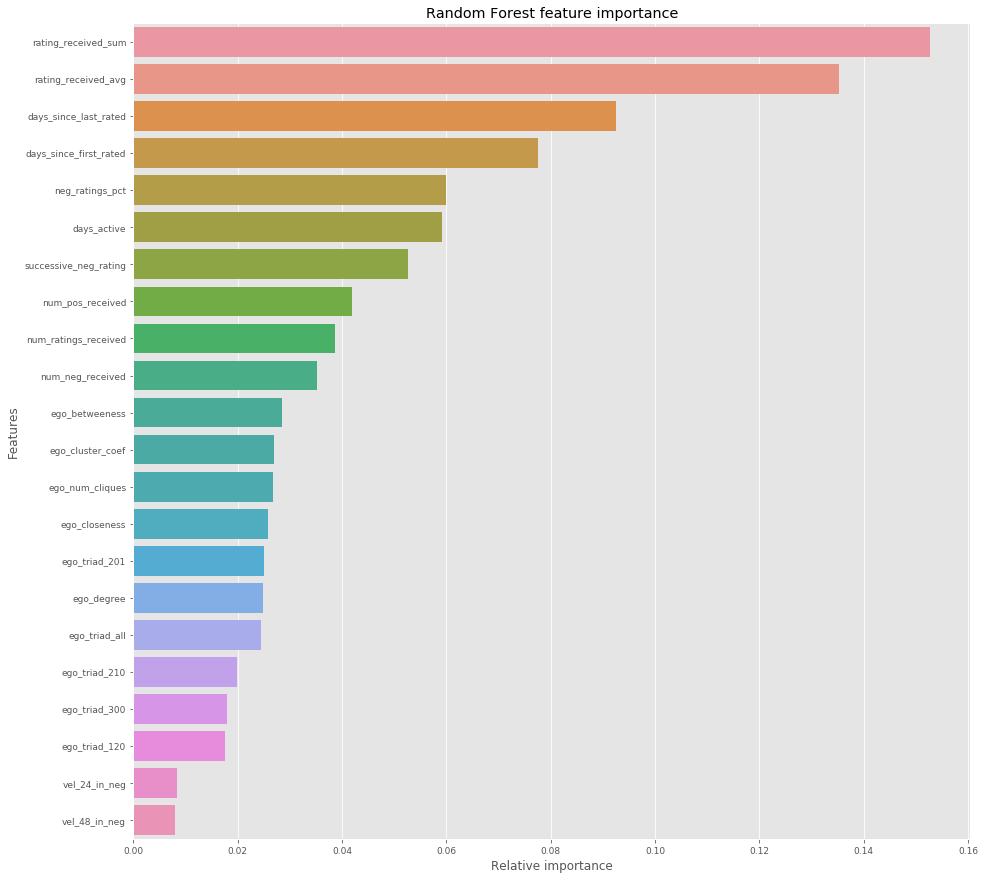

In [163]:
import seaborn as sns
fig = plt.figure(figsize=(15,15))

name = "Random Forest"
indices = np.argsort(RF.feature_importances_)[::-1][:40]
ax1 = sns.barplot(y=X_train.columns[indices][:40],x = RF.feature_importances_[indices][:40] , orient='h')
ax1.set_xlabel("Relative importance",fontsize=12)
ax1.set_ylabel("Features",fontsize=12)
ax1.tick_params(labelsize=9)
ax1.set_title(name + " feature importance")

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

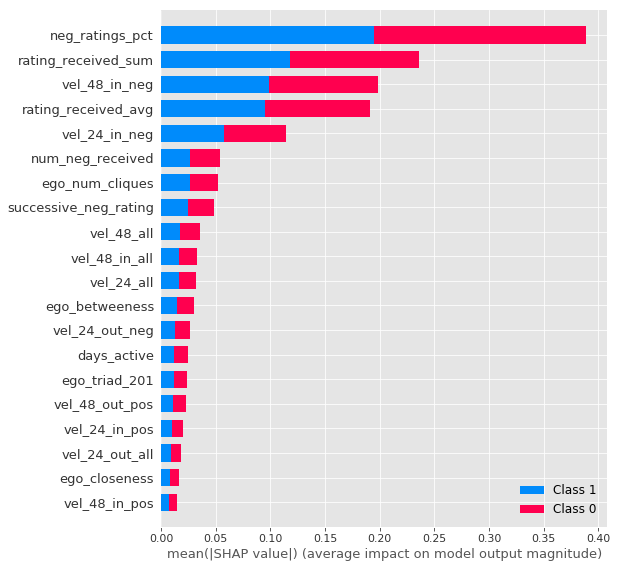

In [110]:
shap_values2 = shap.TreeExplainer(RF).shap_values(test)
shap.summary_plot(shap_values2, X_train)#, plot_type="bar")

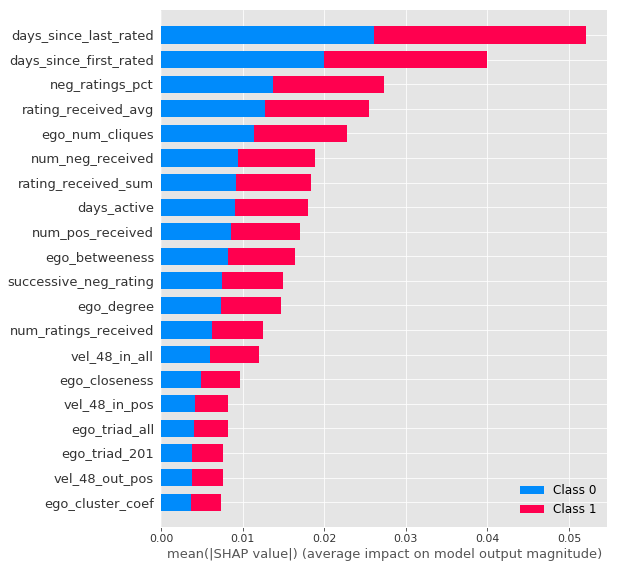

In [95]:
import shap
shap_values = shap.TreeExplainer(RF).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

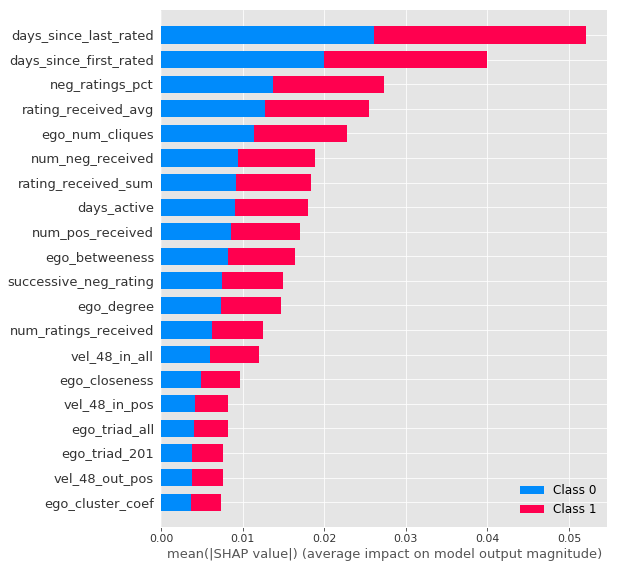

In [108]:
import matplotlib.pyplot as plt
f = plt.figure()
# shap.summary_plot(rf_shap_values, X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# number of unique days in dataset 
# This is the number of iterations of node2vec that will need to be run
# may take 2 days - need to test time on maximum size graph (last day)

# alpha["date"].dt.normalize().nunique()

In [ ]:
alpha['class'].mean()

In [ ]:
# first fraud
alpha_df[alpha_df['rating']<0].sort_values('date')[270:290]

In [ ]:
user_data_in = alpha_df[(alpha_df['ratee']==54) & (alpha_df['date'] < '2010-11-07 21:00:00')]

In [ ]:
import time 
from datetime import datetime

def feature_creation_collusion(bitcoin_df, user, rate_date):
    df = bitcoin_df.copy()
    user_data_in = df[(df['ratee']==user) & ((df['date'] < rate_date) | ((df['date']==rate_date) & (df['rating'] > 0)))]
    if len(user_data_in)==0:
        return np.zeros(8)
    num_ratings_received = len(user_data_in)
    num_neg_received = user_data_in['class'].sum()
    num_pos_received = num_ratings_received - num_neg_received
    neg_ratings_pct = num_neg_received / num_ratings_received
    rating_sum = user_data_in['rating'].sum()
    days_active = (rate_date - user_data_in['date'].min()).days
    _, g = h.build_graph(df, maxdate=rate_date)
    cluster_coef = nx.clustering(g, user)
    g = g.to_undirected()
    num_cliques = nx.number_of_cliques(g, user)

    A = np.array([num_ratings_received, num_neg_received, num_pos_received, 
                  neg_ratings_pct, rating_sum, days_active, cluster_coef, num_cliques])
    A[np.isnan(A)] = 0
    return A

In [ ]:

def feature_iteration_collusion(bitcoin_df):
    start_time = time.time()
    df = bitcoin_df.copy()
    for i, row in df.iterrows():
        user = row['ratee']
        rate_date = row['date']
        num_ratings_received, num_neg_received, num_pos_received, \
        neg_ratings_pct, rating_sum, days_active, cluster_coef, \
        num_cliques = feature_creation_collusion(df, user, rate_date)
        df.at[(i,'num_ratings_received')] = num_ratings_received
        df.at[(i,'num_neg_received')] = num_neg_received
        df.at[(i,'num_pos_received')] = num_pos_received
        df.at[(i,'neg_ratings_pct')] = neg_ratings_pct
        df.at[(i,'rating_sum')] = rating_sum
        df.at[(i,'days_active')] = days_active
        df.at[(i,'cluster_coef')] = cluster_coef
        df.at[(i,'num_cliques')] = num_cliques
        t = time.time() - start_time
        print(f"{t:.0f} seconds execution time for node {user} on {rate_date}")
    return df
alpha_with_ratee_stats = feature_iteration_collusion(alpha_df)

In [ ]:
alpha_with_ratee_stats.to_csv('alpha_with_ratee_stats.csv', index=False)


In [ ]:
alpha_with_ratee_stats.info()

In [ ]:
alpha_with_ratee_stats[alpha_with_ratee_stats['rating']<0].sort_values('cluster_coef', ascending=False).head()

In [ ]:
# decision based on the existence of a negative rating
recall = recall_score(y_test, X_test['rating_sum']<0)
precision = precision_score(y_test, X_test['rating_sum']<0)
print(recall)
print(precision)

In [ ]:
# decision based on total sum of ratings
recall = recall_score(y_test, X_test['num_neg_received']>0)
precision = precision_score(y_test, X_test['num_neg_received']>0)
print(recall)
print(precision)